Implémentation de CLIP Surgery


**objectifs**
 - reproduire les résultats du papier de recherche avec CLIP_Surgery

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c1uupobx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c1uupobx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached wcwidth-0.2.13-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using c

In [3]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-j_9ytj0w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-j_9ytj0w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36636 sha256=d42259977277c18245bac05260fe5069ae693d67785ff2de69feef1d7b538d4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmvqkbh6/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
Note: you may need to restart the kernel to use updated packages.


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-06-15 17:46:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:2450:2c00:13:6e38:acc0:93a1, 2600:9000:2450:7a00:13:6e38:acc0:93a1, 2600:9000:2450:ea00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:2450:2c00:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2,4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2,39G  32,8MB/s    in 73s     

2025-06-15 17:47:46 (33,6 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [22]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
import CLIP_Surgery.clip as clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

In [32]:
model, _ = clip.load("ViT-B/16", device=device)

In [33]:
model.eval()
preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

In [36]:
pil_img = Image.open("./assets/ski.jpg")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)

In [47]:
image = preprocess(pil_img).unsqueeze(0).to(device)
all_texts = [
    'airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle',
    'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow',
    'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground',
    'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform',
    'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa',
    'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood',
    'ski', 'skis', 'goggles', 'jacket', 'helmet', 'woman'
]
target_texts = ['woman', 'ski', 'skis', 'snow']

CLIP: snow


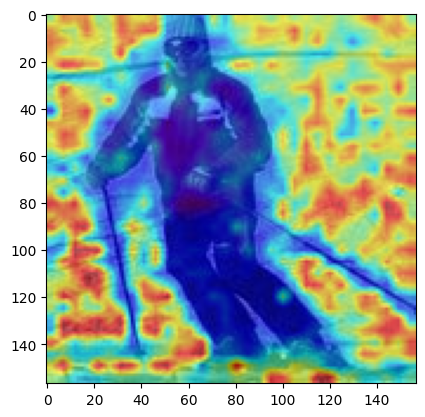

CLIP: ski


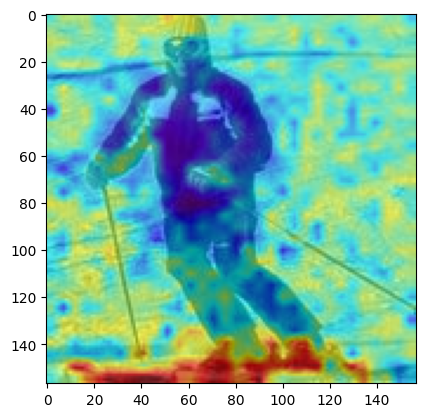

CLIP: skis


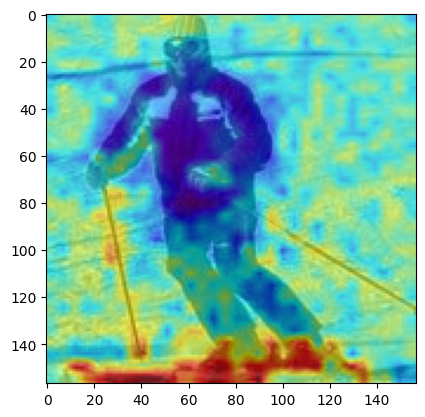

CLIP: woman


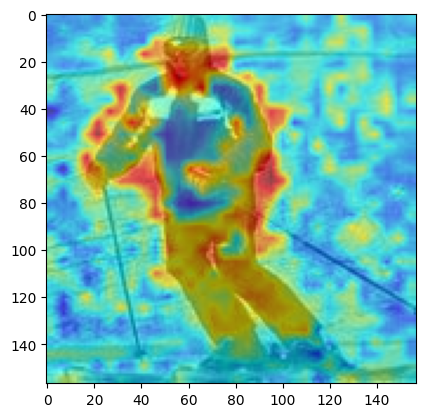

In [48]:
with torch.no_grad():
    # Extract image features
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Similarity map from image tokens with min-max norm and resize, B,H,W,N
    features = image_features @ text_features.t()
    similarity_map = clip.get_similarity_map(features[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP:', all_texts[n])
            plt.imshow(vis)
            plt.show()

In [49]:
model, preprocess = clip.load("CS-ViT-B/16", device=device)
model.eval()

CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

CLIP Surgery: snow


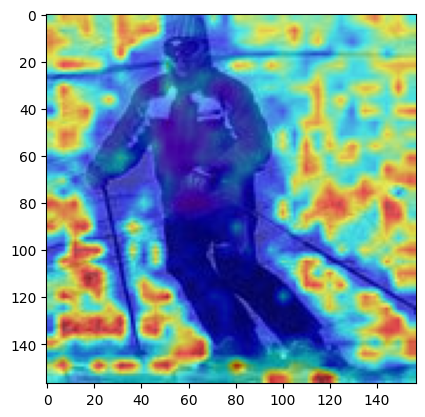

CLIP Surgery: ski


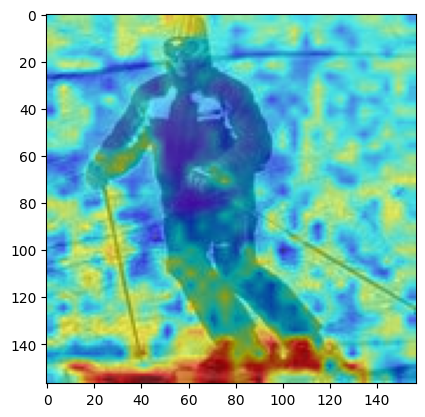

CLIP Surgery: skis


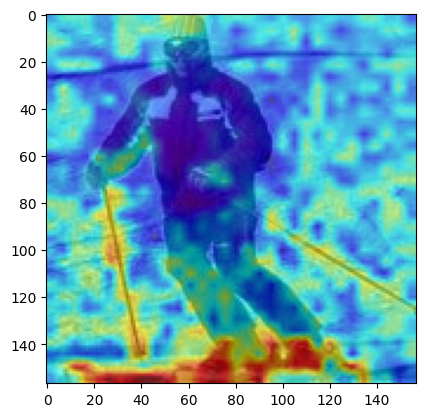

CLIP Surgery: woman


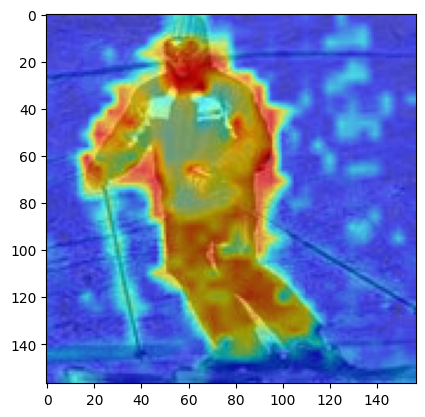

In [50]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery:', all_texts[n])
            plt.imshow(vis)
            plt.show()

In [51]:
preprocess =  Compose([Resize((512, 512), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])
image = preprocess(pil_img).unsqueeze(0).to(device)

CLIP Surgery 512: snow


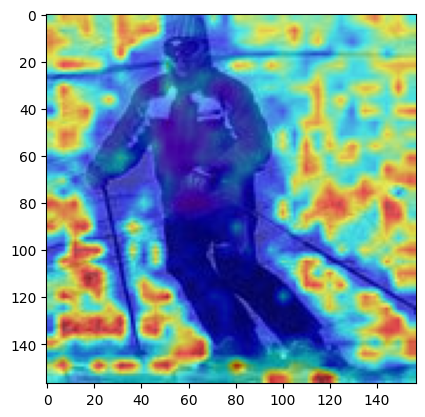

CLIP Surgery 512: ski


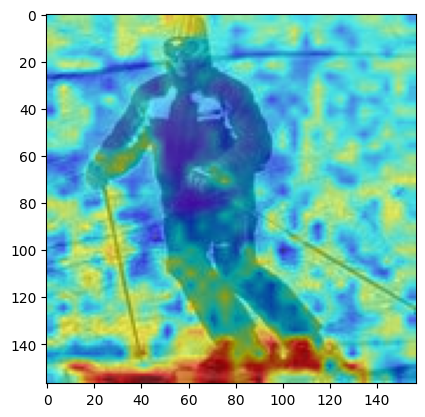

CLIP Surgery 512: skis


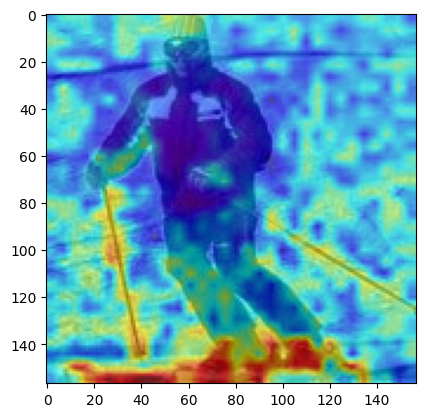

CLIP Surgery 512: woman


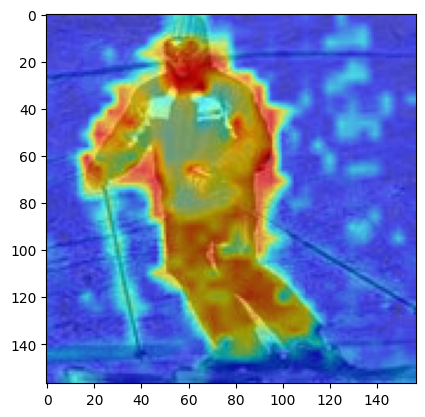

In [52]:
with torch.no_grad():
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])
    
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery 512:', all_texts[n])
            plt.imshow(vis)
            plt.show()

Target = "Woman is skiing"

In [54]:
texts = ['woman is skiing ski']

CLIP Surgery for a single text: woman+ski


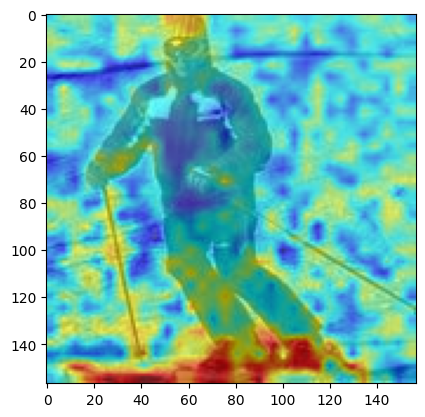

In [55]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # Apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery for a single text:', texts[n])
            plt.imshow(vis)
            plt.show()